<a href="https://colab.research.google.com/github/emanuelcatao/CreditCardFraud/blob/main/CreditCard_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Etapas da Resolução do Problema:

1 - **"Análise exploratória dos dados (EDA)":** Vamos primeiro buscar entender o dataset antes de aplicar os algoritmos. O objetivo primeiro desta etapa é tentar visualizar a distribuição das transações legítimas e fraudulentas, bem como qualquer padrão ou tendência incomum que possa ser observada nessa análise.

2- **Pré-processamento de dados:** Depois de termos feito um reconhecimento do terreno em que estamos trabalhando, vamos lidar com quaisquer dados ausentes (se houverem) e dividir o dataset em conjuntos de treinamento e teste.

3 - **Treinamento e avaliação dos modelos:** Aqui é talvez o que nos interesse mais.
- Primeiro, treinar cada um dos três modelos especificados (Naive Bayes, Árvore de Decisão e KNN) com o conjunto de treinamento.
- Em seguida, avaliar cada modelo usando o conjunto de teste e calcular a precisão, para cada modelo.
- Por fim, visualizar as fronteiras de decisão para as features escolhidas. Para isso, precisaremos escolher duas features para visualização, uma vez que fronteiras de decisão são mais facilmente visualizadas em duas dimensões - isso aqui depende também.

4 - **Conclusão**

---

In [7]:
import pandas as pd

# Carregando o dataset
data = pd.read_csv('./dataset/card_transdata.csv')

print('Só a cabecinha 😏\n\n', data.head(), end='\n\n')

'''
  mostra um resumo do dataframe: qtd_linhas,nomes_colunas,
  qtd_nulos_coluna, tipo_dado_coluna, memoria usada
'''
print(data.info())

Só a cabecinha 😏

    distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0

Aqui o dataset foi carregado e temos uma visão geral dos dados:
- São ao todo 1.000.000 entradas, divididas em 8 colunas (sendo uma delas a "coluna alvo", que contém o indicativo de fraude)
- Não há valores ausentes nas colunas (o que indica que já não precisamos da parte do tratamento de dados ausentes. Isso aqui só aconteceu por que o conjunto de dados é muito bem definido e se trata um problema para estudo).
- Aparentemente cinco dessas colunas, a saber *repeat_retailer*, *used_chip*, *used_pin_number*, *online_order*, e *fraud*, parecem ter dados binários.



In [8]:
print(data.describe())

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%   

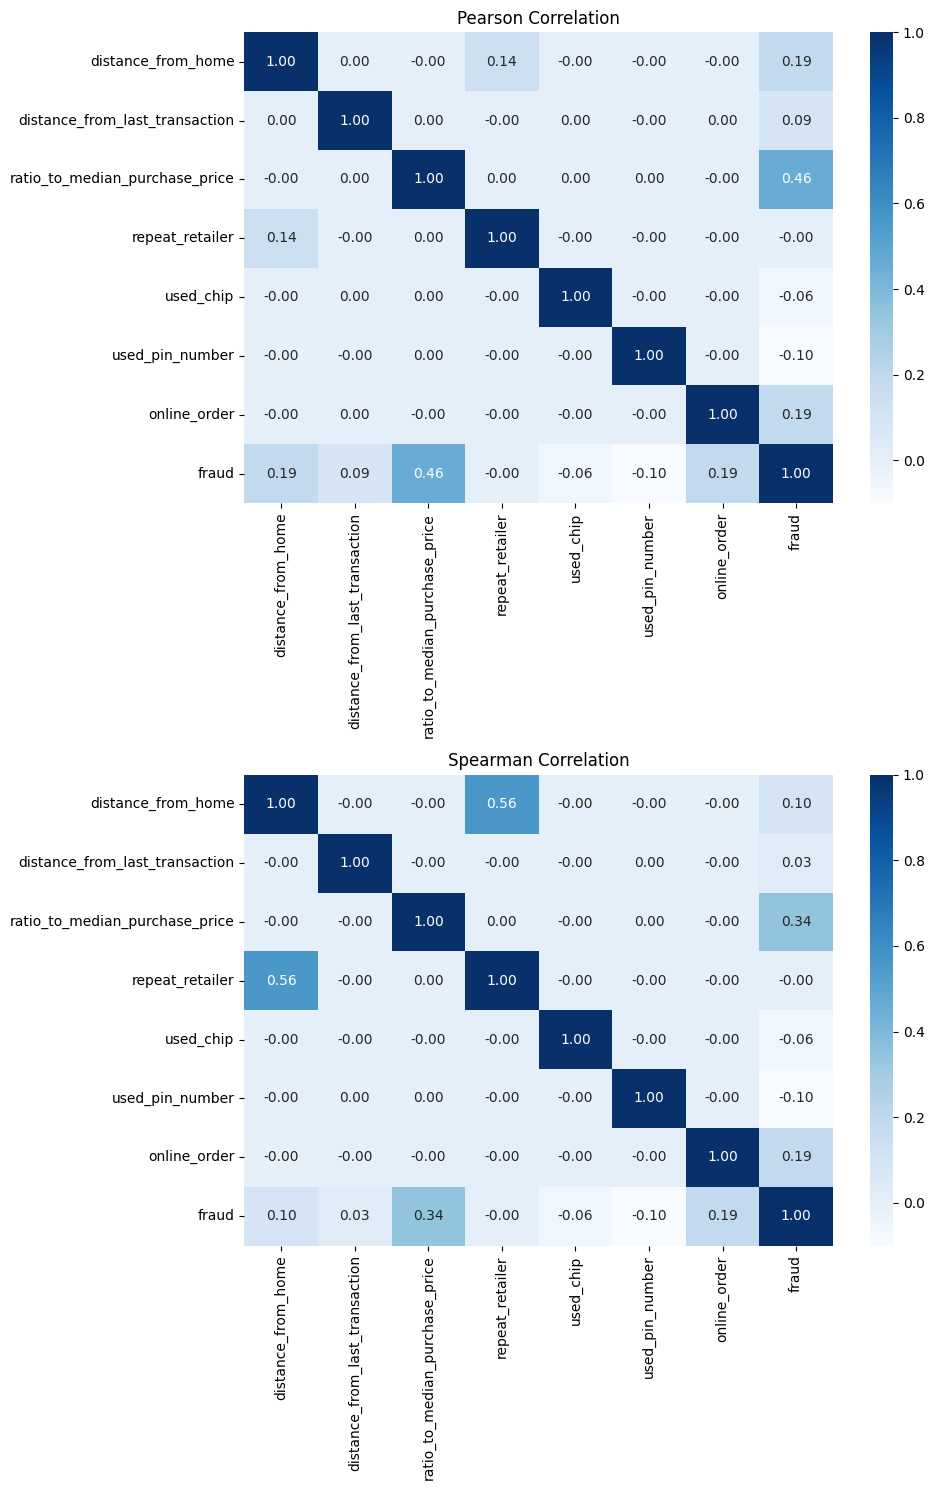

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data.corr()
spearman_corr = data.corr(method='spearman')

fig, ax = plt.subplots(nrows=2, figsize=(10, 15))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt=".2f", cmap="Blues", ax=ax[0])
ax[0].set_title('Pearson Correlation')

sns.heatmap(spearman_corr, xticklabels=spearman_corr.columns, yticklabels=spearman_corr.columns, annot=True, fmt=".2f", cmap="Blues", ax=ax[1])
ax[1].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

In [20]:
'''
    Aqui é basicamente dito, na coluna 'fraud' da tabela, contabilize e o valor é normalizado.
    Basicamente conta todos os valores e atribui a quantidade à chave correspondente. Como é dito para normalizar,
    após contar todos, pega cada um deles e divide proporcionalmente à quantidade total na coluna.
    Isso aqui cria uma serie com o nome da coluna, os valores computados na serie são do tipo float e
    o retorno vai ser a série com a distribuição proporcional dos valores na serie.
'''
fraud_distribution = data['fraud'].value_counts()

print(fraud_distribution) # no colab nao precisa do print, mas fica ae

0    912597
1     87403
Name: fraud, dtype: int64


**distance_from_home**: A média da distância entre a transação atual e o domicílio do titular do cartão é de cerca de 26.63, com um desvio padrão de 65.39. A distância máxima é bem da alta (10632.72) em relação à média (possíveis outliers ou transações muito distantes da residência do titular - internacionais por exemplo). Nessa aqui o banco já bloqueia lul

**distance_from_last_transaction**: A média é de aproximadamente 5.04, mas o desvio padrão é de 25.84, o que é alto. Novamente, vemos que o valor máximo é extremamente alto (11851.10) em comparação com a média, indicando possíveis outliers. (Essa aqui parece ser uma feature importante para identificar fraude).

**ratio_to_median_purchase_price**: A média da proporção do valor da transação atual e a mediana dos valores das transações do cartão é de aproximadamente 1.82. O valor máximo é muito alto (267.80), ou seja, em algumas transações o valor foi muito superior à mediana dos valores das transações. (não significa absolutamente nada)

**repeat_retailer, used_chip, used_pin_number, online_order**: Estes são campos binários. 88% das transações foram feitas com varejistas repetidos, 35% usaram chip, 10% usaram número PIN e 65% foram pedidos online. (sozinhos assim, não significam absolutamente nada)

#### Dataset bastante desbalanceado:

- Transações não-fraudulentas: 912.597 (aproximadamente 91,3%)
- Transações fraudulentas: 87.403 (aproximadamente 8,7%)

Como fraudes são eventos relativamente raros em comparação com transações legítimas, isso era de se imaginar. É importante levar isso em consideração ao treinar e avaliar os modelos, pois a acurácia sozinha pode ser enganosa.

In [10]:
'''
Convertemos para inteiro só para ficar mais intuitivo, mas é besteira tbm
'''
binary_columns = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
data[binary_columns] = data[binary_columns].astype(int)
data

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1,1,0,0,0
999996,19.872726,2.683904,2.778303,1,1,0,0,0
999997,2.914857,1.472687,0.218075,1,1,0,1,0
999998,4.258729,0.242023,0.475822,1,0,0,1,0


In [11]:
from sklearn.model_selection import train_test_split

# Definindo as variáveis independentes e a variável dependente
X = data.drop('fraud', axis=1)
y = data['fraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape #Espera-se 800000 e 200000 respectivamente.

((800000, 7), (200000, 7))

Usei o stratify=y para que a proporção de classes de fraude seja mantida tanto nos conjuntos de treinamento quanto de teste.

Como temos KNN para analisar também, vamos normalizar já que esse algoritmo é sensível à escala das features. Daí:

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-3.53541109e-01,  8.30493627e-02, -5.73726340e-01, ...,
         1.36114699e+00, -3.34632743e-01,  7.32676854e-01],
       [-1.75683248e-01, -1.56580313e-01,  3.15170418e-01, ...,
         1.36114699e+00, -3.34632743e-01,  7.32676854e-01],
       [ 7.84670941e-02, -7.03189758e-02, -5.39589940e-01, ...,
        -7.34674509e-01, -3.34632743e-01,  7.32676854e-01],
       ...,
       [-3.36750661e-01,  1.53923557e+00,  2.11205426e-03, ...,
         1.36114699e+00, -3.34632743e-01,  7.32676854e-01],
       [-1.14724760e-01, -1.72681913e-01, -5.88484643e-01, ...,
        -7.34674509e-01,  2.98835073e+00, -1.36485818e+00],
       [ 3.58360679e-01, -1.85223266e-01,  1.23941439e+00, ...,
         1.36114699e+00, -3.34632743e-01,  7.32676854e-01]])

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Inicializar e treinar o modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
nb_predictions = nb_model.predict(X_test_scaled)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("AUC:", roc_auc_score(y_test, nb_predictions))
print(classification_report(y_test, nb_predictions))

Naive Bayes Results:
Accuracy: 0.950765
AUC: 0.7885695115749137
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    182519
           1       0.79      0.59      0.68     17481

    accuracy                           0.95    200000
   macro avg       0.88      0.79      0.83    200000
weighted avg       0.95      0.95      0.95    200000



**Accuracy** (Precisão global) é de 95%. Isso significa que 95% das transações foram classificadas corretamente.

**AUC** (Area Under the Curve) é de aproximadamente 0.789, um AUC de 0.5 indica um classificador não melhor do que um sorteio aleatório, enquanto um AUC de 1.0 indica um classificador perfeito. Nesse caso ele é um meia bomba.
Ao observar a precisão, recall e F1-score para a classe minoritária (fraudes), vemos que o modelo tem espaço para melhorias.

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Inicializar e treinar o modelo Árvore de Decisão
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
dt_predictions = dt_model.predict(X_test_scaled)

print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("AUC:", roc_auc_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))


Decision Tree Results:
Accuracy: 0.999985
AUC: 0.9999400555937836
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       1.00      1.00      1.00     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



**Accuracy:** quase perfeito.

**AUC** quase perfeito.

A precisão, recall e F1-score são praticamente 1, indicando classificações quase perfeitas.

É de se imaginar um desempenho suspeito, já que detecção de fraudes é um problema bastante complexo (overfitting?). O modelo pode ter memorizado o conjunto de treinamento e pode não ter um desempenho tão bom em novos dados. Como não temos novos dados para teste, vamos ter que partir aqui para uma validação cruzada para ter certeza. (Isso num cenário de mundo real, muito provavelmente isso aqui tá certo nesse cenário controlado, mas é isso)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar e treinar o modelo KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Prever os resultados para o conjunto de teste
knn_predictions = knn_model.predict(X_test_scaled)

print("\nKNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("AUC:", roc_auc_score(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))


KNN Results:
Accuracy: 0.998755
AUC: 0.9951797925352652
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



Os resultados também são excelentes.

AUC de 0.995 indica um classificador quase perfeito.

Precisão, recall e F1-score são muito próximos de 1, o que é excelente.

#### **Validação Cruzada**

In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#10 folds, pq sim
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nb = GaussianNB()
nb_scores = cross_val_score(nb, X_train_scaled, y_train, cv=skf, scoring="accuracy")
print(f"Naive Bayes - Accuracy: {nb_scores.mean():.4f} (+/- {nb_scores.std():.4f})")

dt = DecisionTreeClassifier()
dt_scores = cross_val_score(dt, X_train_scaled, y_train, cv=skf, scoring="accuracy")
print(f"Decision Tree - Accuracy: {dt_scores.mean():.4f} (+/- {dt_scores.std():.4f})")

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf, scoring="accuracy")
print(f"KNN - Accuracy: {knn_scores.mean():.4f} (+/- {knn_scores.std():.4f})")

Naive Bayes - Accuracy: 0.9503 (+/- 0.0007)
Decision Tree - Accuracy: 1.0000 (+/- 0.0000)
KNN - Accuracy: 0.9988 (+/- 0.0002)


Tanto a Decision Tree, quanto o KNN continuam mostrando uma performance bastante alta, mesmo após a validação cruzada.

Vamos somente passar por mais uma checagem, com o uso de hiperparâmetros e então prosseguir.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Defina os parâmetros a serem testados
param_dist = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10, 15]
}

tree_clf = DecisionTreeClassifier()

random_search = RandomizedSearchCV(tree_clf, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)

random_search.fit(X_train_scaled, y_train)

# Exiba os melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)

# Treine o modelo com os melhores parâmetros
best_tree_clf = random_search.best_estimator_


Melhores parâmetros: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}


Encontramos aqui os melhores hiperparâmetros, dentre os que haviamos listado.

Agora fazemos uma nova predição considerando esses novos hiperparâmetros:

In [18]:
dt_predictions = best_tree_clf.predict(X_test_scaled)

print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("AUC:", roc_auc_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))


Decision Tree Results:
Accuracy: 0.999985
AUC: 0.9999400555937836
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       1.00      1.00      1.00     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



A Decision Tree continuou mostrando a mesma performance. Então aqui já estamos mais propensos a crer que seja devido à características dos dados mesmo.

Sigamos agora para  a escolha das features. Dado que estamos usando uma decision tree, vamos usar o atributo importance dela e deixar que isso seja nossa escolha.

In [33]:
feature_importances = best_tree_clf.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                          Feature  Importance
2  ratio_to_median_purchase_price    0.422638
6                    online_order    0.257504
0              distance_from_home    0.109355
5                 used_pin_number    0.104820
4                       used_chip    0.067799
1  distance_from_last_transaction    0.034766
3                 repeat_retailer    0.003118


In [44]:
X_train_selected = X_train_scaled[:, [2, 6]]
X_test_selected = X_test_scaled[:, [2, 6]]

#Treinando novamente para as features selecionadas
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_selected, y_train)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_selected, y_train)

nb_predictions = naive_bayes_model.predict(X_test_selected)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))

knn_predictions = knn_model.predict(X_test_selected)

print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))

best_tree_clf.fit(X_train_selected, y_train)

print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))

Naive Bayes Results:
Accuracy: 0.9385
KNN Results:
Accuracy: 0.96255

Decision Tree Results:
Accuracy: 0.999985


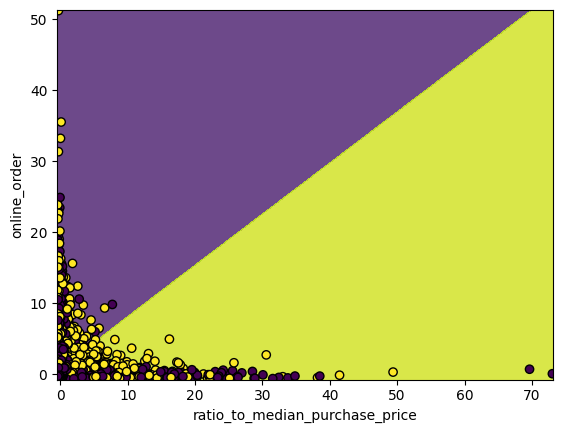

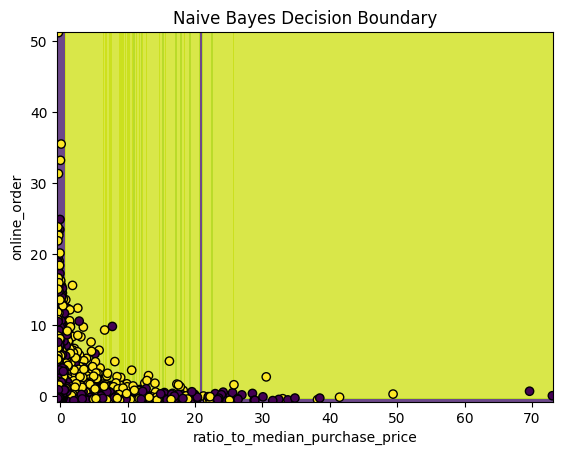

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Defina as fronteiras de decisão
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('ratio_to_median_purchase_price')
    plt.ylabel('online_order')
    plt.show()

X_selected = X_test_scaled[:, [0, 2]]

plot_decision_boundary(naive_bayes_model, X_selected, y_test)
plt.title('Naive Bayes Decision Boundary')

plot_decision_boundary(best_tree_clf, X_selected, y_test)
plt.title('Decision Tree Decision Boundary')

plot_decision_boundary(knn_model, X_selected, y_test)
plt.title('KNN Decision Boundary')
